# meassurement of the accuracy 

accuracy is 
mean{ p in dotplot @ i,j  |  i,j in real_structure }

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from eden.util import configure_logging
import logging
configure_logging(logging.getLogger(),verbosity=3)
import sys
sys.path.insert(0,'..')
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style><style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>')
import matplotlib.pyplot as plt

backend module://ipykernel.pylab.backend_inline version unknown


# Load data

In [2]:
import rna_tools.rna_io as rio

def getdata():
    return rio.get_all_data("../data/RNA16.react","../data/RNA16.dbn")  # {key: rea, seq, stru}

data = getdata()

for k,v in data.items():print k,"\t",  len(v[1])

TRP5 	202
5srRNA 	170
GLYCFN 	205
RNAsep 	154
adenin 	71
Z-CIDGMP-1 	135
R009 	1542
ZHCV 	95
MDLOOP 	80
srRNA 	120
p564 	155
tRNAphe 	76
ZGLY 	198
23sRNA 	2904
ADDRSW 	121
tRNA-asp 	75


# train predict

In [3]:
import simushape as sim
from rna_tools.rnaplfold import rnaplfold

data = getdata()
model  = sim.make_model(data,['23sRNA','R009'],sim.make_forestregressor())
data.pop("23sRNA")
data.pop("R009")
keys = data.keys()

def get_str(seq):
    for _, data_seq, db in data.values():
        if seq == data_seq:
            return [db]
    print "SHIT"

# acc_calculator needs seq struct rea
predictions = { k: (data[k][1],data[k][2],sim.predict(model,data[k][1], seq_to_db_function=get_str)) for k in keys  }

shaker_plain = { k: (data[k][1],data[k][2],sim.predict(model,data[k][1])) for k in keys  }


# get accuracy

In [4]:
from rna_tools.sukosd import sukosd
from rna_tools.rna_accuracy import get_structure_accuracy

acc_shaker = {k: get_structure_accuracy (*predictions[k])  for  k in keys} 
acc_shaker_plain = {k: get_structure_accuracy(*shaker_plain[k]) for  k in keys} 
predictions_suko = { k: (data[k][1],data[k][2],sukosd(data[k][2])) for k in keys }

acc_suko = {k: get_structure_accuracy(*predictions_suko[k])  for  k in keys} 
acc_real = {k: get_structure_accuracy(data[k][1],data[k][2],data[k][0])  for  k in keys}
acc_noshape = {k: get_structure_accuracy(data[k][1],data[k][2],None)  for  k in keys}




acc_thoretical_best = {k: get_structure_accuracy(data[k][1],data[k][2],[1.0 if e =='.' else 0.0 for e in data[k][2]]) for k in keys} ### DOES THIS WORK? 



# Visualize 

findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans (u'/home/ikea/.local/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


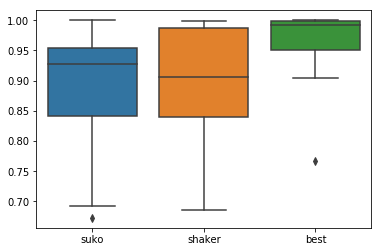

In [5]:
import pandas
import numpy as np
index= ['suko',"shaker", "best","shaker_plain",'real',"no_shape"]
data = map(lambda x: [x[k] for k in keys] ,[acc_suko, acc_shaker,acc_thoretical_best,acc_shaker_plain, acc_real, acc_noshape])

#import notebook_helper as nbh
#nbh.boxplotDraw(data,index,"i am the fig title","","FUCKOFF")

import seaborn as sns
sns.boxplot(data=pandas.DataFrame(data[:3], index=index[:3]).T)

plt.title("SOME TITLE")
plt.grid()

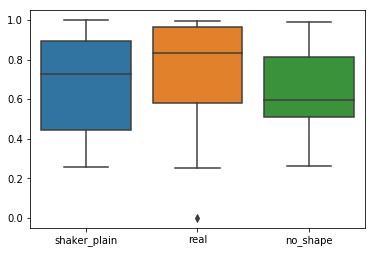

In [6]:
sns.boxplot(data=pandas.DataFrame(data[3:], index=index[3:]).T)
plt.title("SOME TITLE")
plt.grid()

In [7]:

map(lambda x:x.append(np.mean(x)),data)
df = pandas.DataFrame(data, columns=keys+['mean'], index=index).T

print df.to_latex()

\begin{tabular}{lrrrrrr}
\toprule
{} &      suko &    shaker &      best &  shaker\_plain &      real &  no\_shape \\
\midrule
TRP5       &  0.838909 &  0.901676 &  0.958850 &      0.898397 &  0.821419 &  0.838098 \\
5srRNA     &  0.923128 &  0.930797 &  0.997156 &      0.257348 &  0.252744 &  0.260634 \\
GLYCFN     &  0.931366 &  0.983152 &  0.999256 &      0.410720 &  0.000000 &  0.565605 \\
RNAsep     &  0.693169 &  0.685207 &  0.766092 &      0.681290 &  0.676623 &  0.530544 \\
adenin     &  0.958671 &  0.988319 &  0.999496 &      0.988029 &  0.981553 &  0.871697 \\
Z-CIDGMP-1 &  0.672669 &  0.839113 &  0.987850 &      0.772223 &  0.759976 &  0.727020 \\
ZHCV       &  0.890160 &  0.808637 &  0.904532 &      0.835880 &  0.533042 &  0.744884 \\
MDLOOP     &  0.999780 &  0.997989 &  0.999880 &      0.997949 &  0.991718 &  0.988975 \\
srRNA      &  0.936818 &  0.800447 &  0.971363 &      0.278642 &  0.849606 &  0.274786 \\
p564       &  0.937610 &  0.895183 &  0.947829 &      0.644343 

In [8]:
from tabulate import tabulate 
print tabulate(df, headers="keys", tablefmt="orgtbl")

|            |     suko |   shaker |     best |   shaker_plain |     real |   no_shape |
|------------+----------+----------+----------+----------------+----------+------------|
| TRP5       | 0.838909 | 0.901676 | 0.95885  |       0.898397 | 0.821419 |   0.838098 |
| 5srRNA     | 0.923128 | 0.930797 | 0.997156 |       0.257348 | 0.252744 |   0.260634 |
| GLYCFN     | 0.931366 | 0.983152 | 0.999256 |       0.41072  | 0        |   0.565605 |
| RNAsep     | 0.693169 | 0.685207 | 0.766092 |       0.68129  | 0.676623 |   0.530544 |
| adenin     | 0.958671 | 0.988319 | 0.999496 |       0.988029 | 0.981553 |   0.871697 |
| Z-CIDGMP-1 | 0.672669 | 0.839113 | 0.98785  |       0.772223 | 0.759976 |   0.72702  |
| ZHCV       | 0.89016  | 0.808637 | 0.904532 |       0.83588  | 0.533042 |   0.744884 |
| MDLOOP     | 0.99978  | 0.997989 | 0.99988  |       0.997949 | 0.991718 |   0.988975 |
| srRNA      | 0.936818 | 0.800447 | 0.971363 |       0.278642 | 0.849606 |   0.274786 |
| p564       | 0.9376

---